# Aprendizado Supervisionado

Fontes da aula de hoje:
1. Capítulos 19 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)

3. Várias páginas da documentação da ``scikit-learn``

3. Aula do Professor Mark Crovella (https://github.com/mcrovella/CS506-Computational-Tools-for-Data-Science/blob/master/15-Classification-II-kNN.ipynb).
4. Aula do Professor Mark Crovella (https://github.com/mcrovella/CS506-Computational-Tools-for-Data-Science/blob/master/14-Classification-I-Decision-Trees.ipynb).



# Introdução

Aprendizado supervisionado é uma área de aprendizado de máquina que tem o objetivo de **aprender** a partir de dados "rotulados".

Há duas tarefas principais:
* Regressão
* Classificação

Nesse contexto, os objetos de estudo serão uma matriz $\mathbf{X} \in \mathbb{R}^{n \times d}$ e um vetor $\mathbf{y}$, onde:
* $n$ é o número de objetos; e
* $d$ é a dimensionalidade de cada objeto.
* $y_i$ é o rótulo (ou valor) associado a $\mathbf{x}_i$

Nessa disciplina, focaremos em **classificação**, mas boa parte dos conceitos também se aplicam à **regressão**.

## Exemplo Clássico - Reconhecimento de Dígitos

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
import seaborn as sns

sns.set()

In [ ]:
digits = datasets.load_digits(return_X_y = False)
df = pd.DataFrame(digits.data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


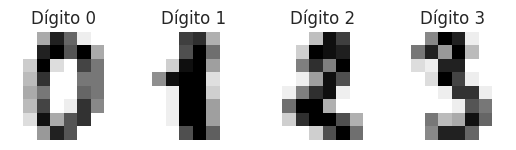

In [ ]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Dígito %i' % label)

**Perguntas:**

*  Dada uma imagem de um número, qual é o dígito equivalente?
*  Qual o custo de uma predição errada?

# O problema de Classificação (uma definição simplificada)

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

No exemplo acima, quem seriam os $\mathbf{x}_i$'s e $y_i$'s?

## Qualquer $f$ serve?

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

- **Satisfazer apenas o requisito 1 é fácil!**
- **Satisfazer 1 e 2 simultaneamente é difícil!**

## *Dumb Classifier*

### Pergunta

Qual seria um classificador simples que satisfaz o requisito (1), mas não satisfaz (2)?

### Resposta

Seja $\mathbf{x}$ um elemento a ser classificado. Considere o seguinte classificador:

$$f(\mathbf{x}) = \begin{cases} \text{Se } \mathbf{x} \text{ está em } D \text{, retorne o rótulo associado}\\
\text{Caso contrário, retorne um rótulo aleatório (uniformemente entre os rótulos válidos)}.
\end{cases}$$

Veja que $f$ acerta em 100% dos casos em que $\mathbf{x}$ está em $D$. Logo, o requisito (1) é satisfeito.

Mas e o requisito 2? O classificador proposto é incapaz de generalizar para situações não conhecidas.

Esse problema está relacionado ao conceito de **overfitting**.

### Overfitting

Ocorre quando o modelo explica tão bem o conjunto de dados usado durante o aprendizado, que é incapaz de generalizar para dados não vistos.

Considere o seguinte exemplo para a tarefa de regressão (da biblioteca [scikit-learn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)):

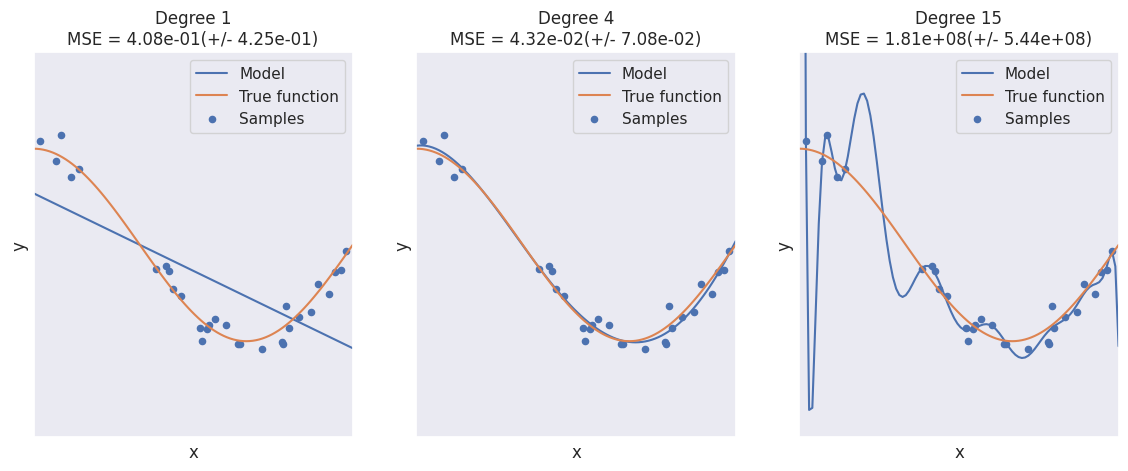

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

Nessa disciplina, veremos:
1. Algumas formas interessantes de se construir bons modelos
2. Metodologias experimentais para garantir que nosso modelo seja **bom** e **generalizável**.

# $k$ Vizinhos mais próximos - KNN

Como para qualquer classificador, o KNN ($k$-*Nearest Neighbors*) é treinado com um conjunto rotulado de dados (comumente chamado de conjunto de treino).

No entanto, o treinamento do classificador faz muito pouco. Ele apenas armazena o conjunto de dados (instâncias e rótulos).

In [ ]:
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

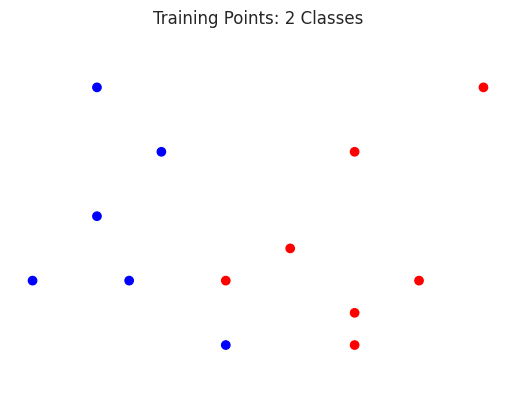

In [ ]:
demo_y = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
demo_X = np.array([[-3,1], [-2, 4], [-2, 2], [-1.5, 1], [-1, 3], [0, 0], [1, 1.5], [2, 0.5], [2, 3], [2, 0], [3, 1], [4, 4], [0, 1]])
test_X = [-0.3, 0.7]
#
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
plt.axis('equal')
plt.axis('off')
plt.title('Training Points: 2 Classes');

A ideia do classificador KNN é que, na tarefa de teste (i.e., classificar uma instância desconhecida), ele simplesmente "olha" os pontos do conjunto de treinamento que estão mais próximos do ponto consultado. A classe de retorno é baseada na classe de tais "vizinhos".

Por "mais próximo", geralmente, estamos falando em termos de distância Euclidiana.

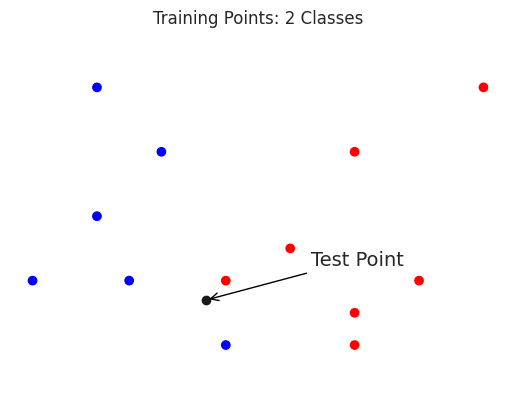

In [ ]:
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
plt.plot(test_X[0], test_X[1], 'ok')
plt.annotate('Test Point', test_X, [75, 25],
             textcoords = 'offset points', fontsize = 14,
             arrowprops = {'arrowstyle': '->', 'color': 'black'})
plt.axis('equal')
plt.axis('off')
plt.title('Training Points: 2 Classes');

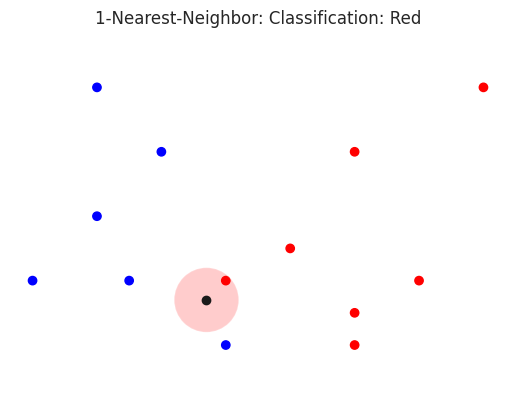

In [ ]:
import matplotlib as mp

plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
plt.plot(test_X[0], test_X[1], 'ok')
ax=plt.gcf().gca()
circle = mp.patches.Circle(test_X, 0.5, facecolor = 'red', alpha = 0.2)
plt.axis('equal')
plt.axis('off')
ax.add_artist(circle)
plt.title('1-Nearest-Neighbor: Classification: Red');

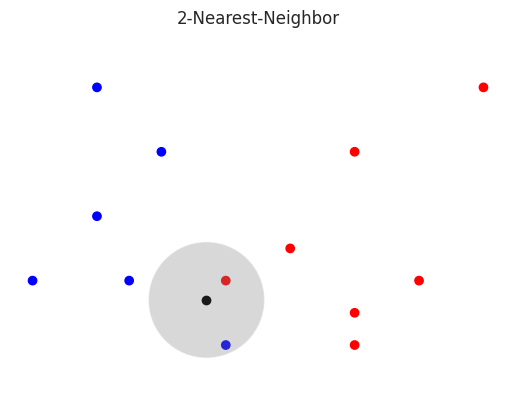

In [ ]:
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
test_X = [-0.3, 0.7]
plt.plot(test_X[0], test_X[1], 'ok')
ax=plt.gcf().gca()
    #ellipse = mp.patches.Ellipse(gmm.means_[clus], 3 * e[0], 3 * e[1], angle, color = 'r')
circle = mp.patches.Circle(test_X, 0.9, facecolor = 'gray', alpha = 0.3)
plt.axis('equal')
plt.axis('off')
ax.add_artist(circle)
plt.title('2-Nearest-Neighbor');

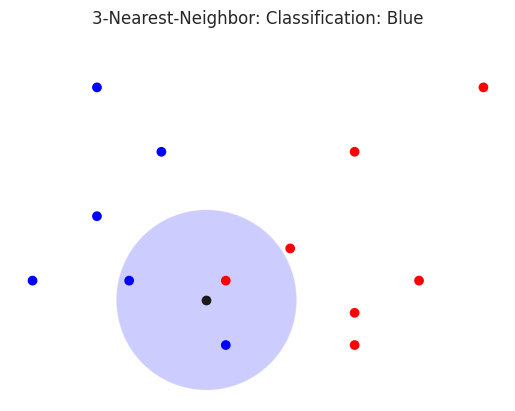

In [ ]:
plt.figure()
ax=plt.gcf().gca()
    #ellipse = mp.patches.Ellipse(gmm.means_[clus], 3 * e[0], 3 * e[1], angle, color = 'r')
circle = mp.patches.Circle(test_X, 1.4, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
test_X = [-0.3, 0.7]
plt.plot(test_X[0], test_X[1], 'ok')
plt.axis('equal')
plt.axis('off')
plt.title('3-Nearest-Neighbor: Classification: Blue');

## Perguntas importantes

1. Como implementar de forma eficiente?
2. Como escolher $k$?
3. Como usar na ``scikit-learn``?

## Respostas

1. Há Estruturas de Dados apropriadas para a tarefa (basicamente, são alguns tipos especiais de árvores);
2. Cenas das próximas aulas. $k$ é um hiperparâmetro e há uma metodologia para escolhê-lo;
3. Fácil (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), veja um exemplo abaixo.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 30) # 1, 3, ...

In [ ]:
knn.fit(digits.data, digits.target); # X e y

In [ ]:
yPredito = knn.predict(digits.data) # prevendo os rótudos dos dados que eu use pra treinar o modelo...

In [ ]:
len(np.where(digits.target == yPredito)[0]) / len(yPredito)

0.9721758486366165

**WARNING:** o código acima é apenas para exemplificar o uso da biblioteca. Testar um classificador no mesmo conjunto que foi utilizado para treiná-lo é uma **péssima** prática. Veremos como avaliar um classificador na próxima aula.

# Árvores de Decisão

O objetivo é formar uma "árvore" de regras a partir dos dados. Cada nó da árvore é um "teste" com base em algum atributo e cada aresta equivale à saída de um teste.

### Árvore de decisão para objetos defeituosos

![alt text](https://github.com/gaabrielfranco/datasets-minicurso/blob/master/figures/dt.png?raw=true)

## Introdução

Vamos começar mostrando como uma árvore de decisão funciona.

Neste momento, vamos assumir que já temos uma pronta em mãos para o seguinte problema de classificação.
Queremos saber se:
- Um indivíduo vai dar "calote" em um empréstimo (rótulo ``Yes`` ou ``No``)
Com base nos atributos:
- Restituição do Imposto de Renda (*refund*)
- Se o indivíduo é casado (*Marital Status*)
- Salário Anual (*Taxable Income*).

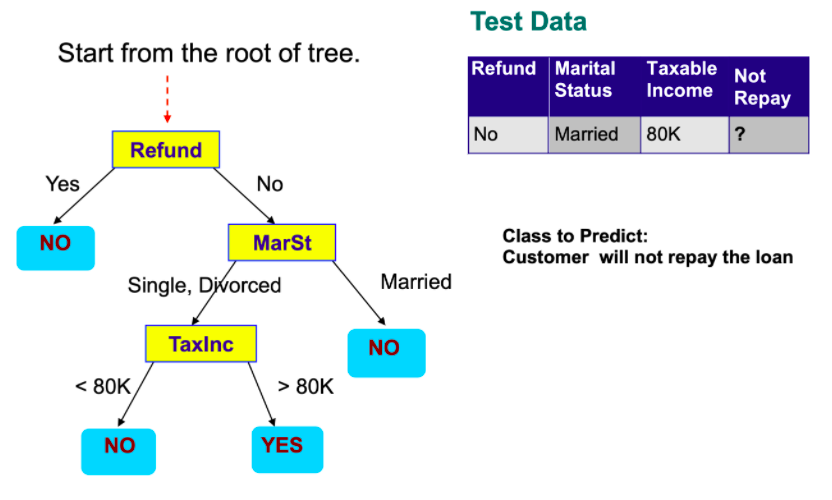

Nós então caminhamos na árvore, fazendo uma decisão em cada nó interno, o que nos leva a um novo nó.

Cada nó examina uma única característica (atributo ou *feature*) do item a ser classificado.

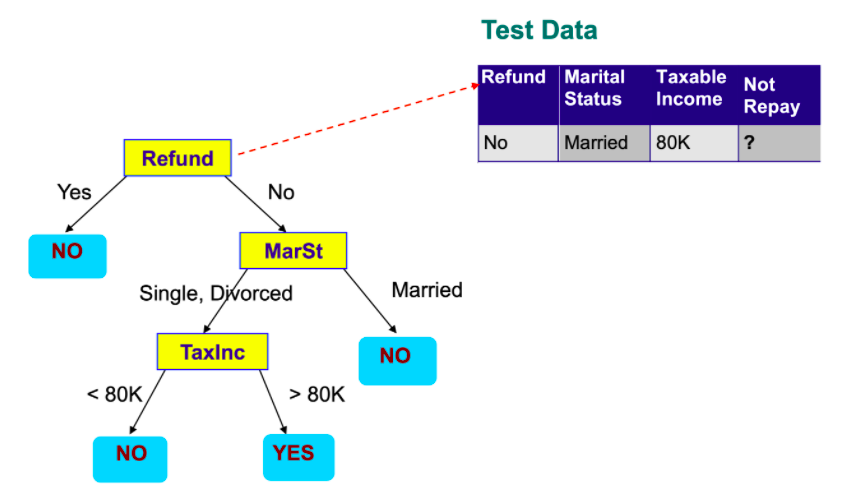

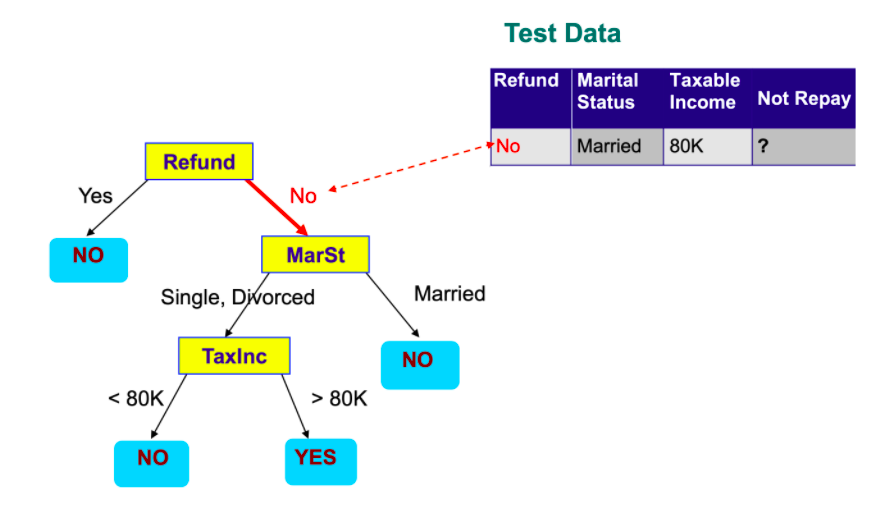

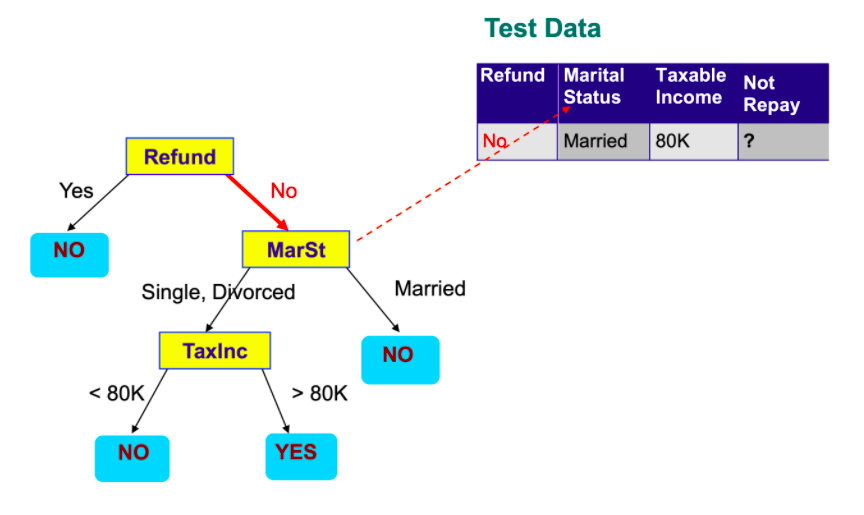

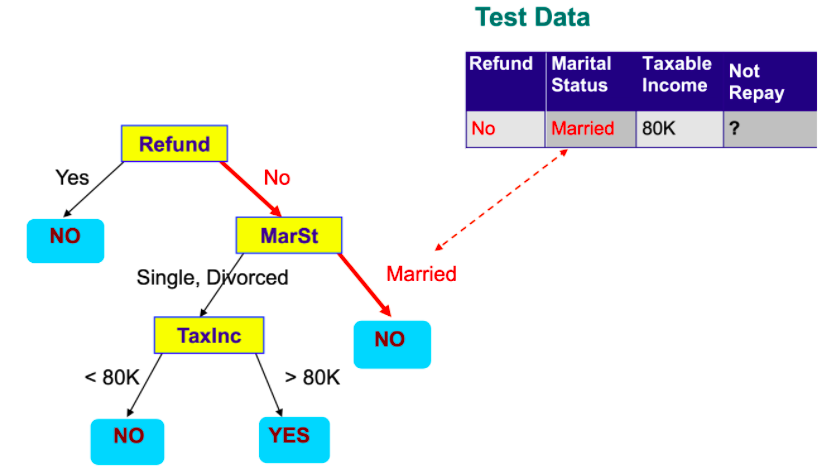

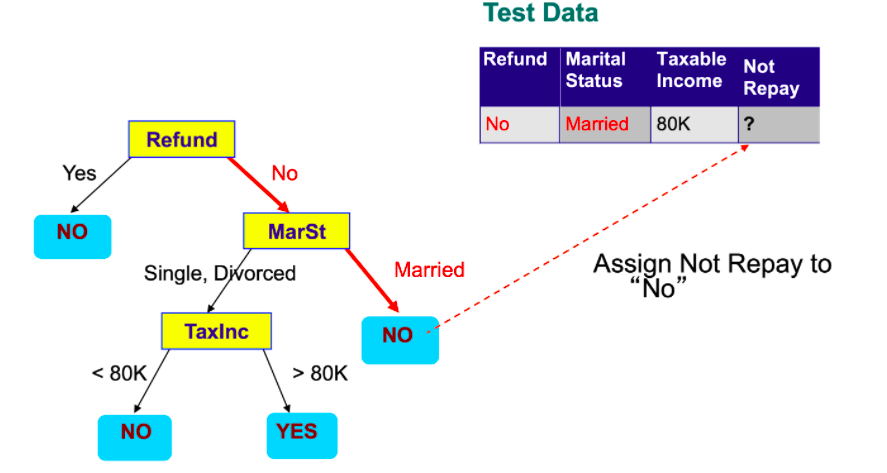

Nós concluímos que este indivíduo é classificado como **não dará "calote"**.

É importante ressaltar que árvores de decisão podem ser utilizadas também para prever valores numéricos (i.e., para regressão).

O termo *Classification and Regression Tree* (CART) é comumente utilizado -- apesar de que o termo refere-se a um tipo específico de algoritmo de criação de árvores de decisão.

## Construindo (*Learning*) uma árvore de decisão

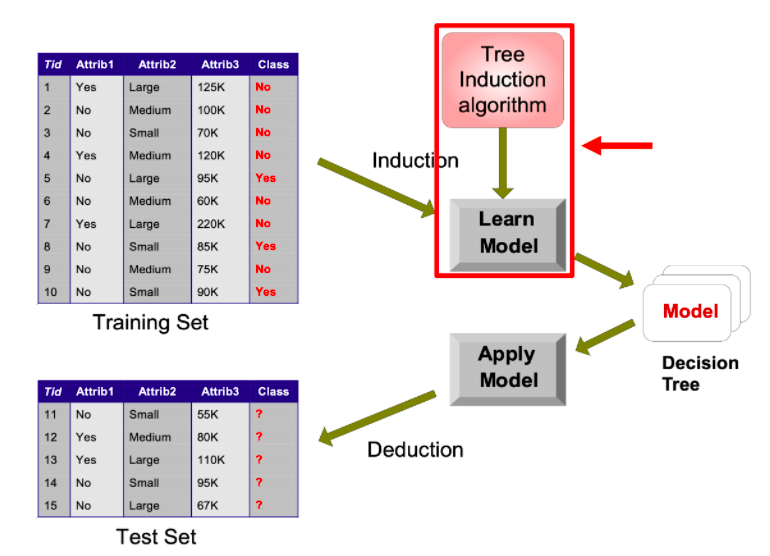

Até agora, nós dicutimos como utilizar uma ávore de decisão (parte de baixo da figura).

Como podemos construir uma? Qual algoritmo utilizar?

Vários algoritmos foram propostos ao longo dos anos (todos se baseiam em ideias similares):
1. Algoritmo de Hunt (um dos primeiros)
2. CART
3. ID3, C4.5
4. SLIQ, SPRINT
5. ...

Vamos analisar um pouco do algoritmo de Hunt (para ilustrar a ideia geral).

## Algoritmo de Hunt

O algoritmo de Hunt constrói a árvore nó por nó, começando pela raíz.

A entrada do algoritmo é o conjunto de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$.

Durante a construção da árvore, nós dividimos o conjunto de treinamento em porções menores.

Vamos considerar o conjunto de objetos sendo analisados no nó $t$ por $D_t$. Temos as seguintes situações:
1. Se $D_t$ contém objetos pertencentes a uma única classe, $y$, então $t$ passa a ser um nó folha da classe $y$ e o processo recursivo não continua.
2. Se $D_t$ contém objetos pertencentes a mais de uma classe, **escolha** um atributo para **dividir** $D_t$ em conjuntos menores. Cada subconjunto será um nó filho do nó relativo a $D_t$. Aplique o procedimento recursivamente a cada novo nó até que algum critério de parada seja encontrado.

A parte mais desafiadora do algoritmo é decidir como especificar o processo de divisão de um nó.

Em geral, utiliza-se uma estratégia gulosa. Nós vamos dividir um nó tomando como base um teste sobre um atributo que otimize algum critério.

Perguntas importantes:
1. Como especificar o atributo a ser utilizado para dividir um conjunto?
2. Como especificar o teste sobre esse atributo?
3. Como determinar quando devemos parar de dividir um nó?

### Especificando a condição de um teste

Como especificamos um teste depende do tipo de atributo que estamos trabalhando:
- Nominal (categórico)
- Ordinal (e.g., pequeno, médio e grande)
- Contínuo

O teste também depende do tipo de divisão que podemos fazer no nó. A divisão pode ser **múltipla** (**multi-way**) ou **binária**.

#### Atributo nominal

Em uma divisão múltipla, nós podemos usar o número de partições igual ao número de valores distintos do atributo.

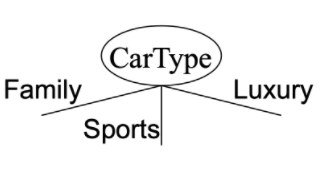

Em uma divisão binária, podemos dividir os valores de acordo com dois grupos. Nesse caso, é necessário encontrar a maneira ótima de dividir os valores em dois grupos.

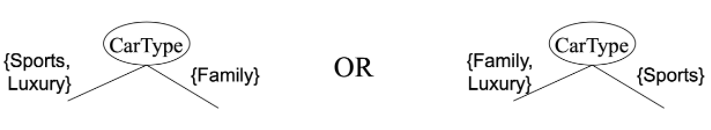

#### Atributo ordinal

Um atributo ordinal é similar a um nominal, exceto no fato de que os valores possuem uma ordem. Assim, podemos especificar o teste em termos de um limiar. Isso simplifica o processo de busca por uma partição (para divisões binárias).

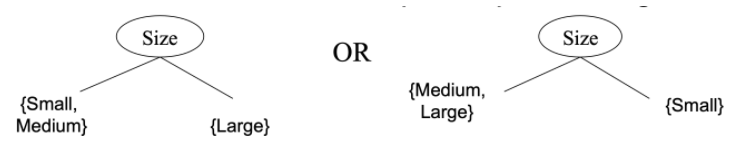

#### Atributos contínuos

Atributos numéricos/contínuos podem ser considerados de duas formas.

Eles podem ser discretizados para formar atributos ordinais.

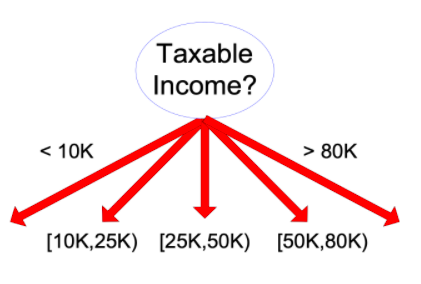

Ou podem ser particionados por meio de um limiar para formar uma divisão binária.

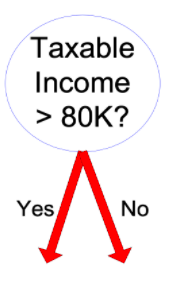

Observe que encontrar boas partições para atributos nominais pode ser uma tarefa cara, possivelmente envolvendo busca sobre um grande número de possíveis partições.

No entanto, para atributos ordinais ou contínuos, o processo é simplificado por uma varredura dos valores.

### Determinando a melhor divisão

Nossa estratégia algoritmica é dividir os conjuntos de dados de forma a melhorar a acurácia da classificação no conjunto de dados fornecido para treinar o modelo.

**Quando a acurácia da classificação é maximizada?**

Quando cada nó folha contém elementos que pertencem a mesma classe (têm o mesmo rótulo).

Considere o caso abaixo:

Em um nó da árvore, antes da divisão em filhos, nós temos:
- 10 elementos da classe 0
- 10 elementos da classe 1

Há 3 atributos que podem ser utilizados para fazer a divisão do nó. Qual divisão é melhor?

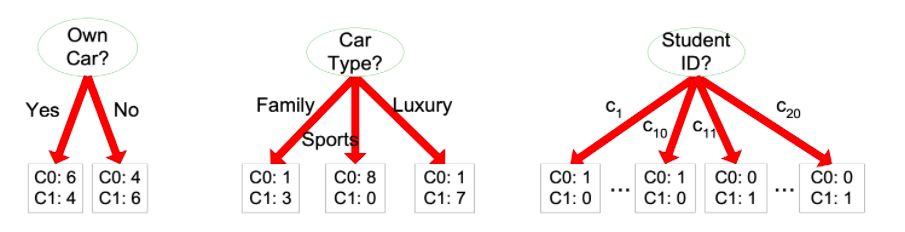

O atributo "Car Type" gera uma divisão mais homogênea.

Usar o atributo "Student ID" cria umar partição perfeita no conjunto de treinamento, mas pode gerar overfitting (veremos mais em breve).

Por agora, vamos focar apenas em maximizar a homogeneidade das divisões. Para isso, precisamos de uma forma de quantificar a pureza dos elementos de cada nó.

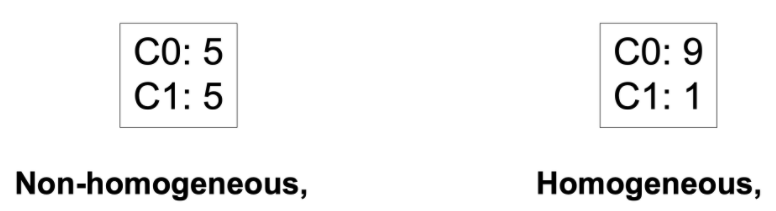

Várias medidas foram propostas ao longo dos anos.

1. Índice GINI
2. Entropia
3. Erro na classificação

Vamos utilizar o índice de GINI como exemplo, uma vez que é umas das medidas mais utilizadas.

#### Índice de GINI

Nós vamos pensar no conjunto de elementos em cada nó como uma distribuição sobre as classes.

Para um nó $t$, vamos denotar por $P(j|t)$ a frequência relativa da classe $j$ no nó $t$.

O índice de GINI mede o grau de balanceamento na distribuição. É definido por
$$1 - \sum_jP(j|t)^2.$$

À medida que nós são divididos na construção da árvore, o valor do índice de GINI diminui.

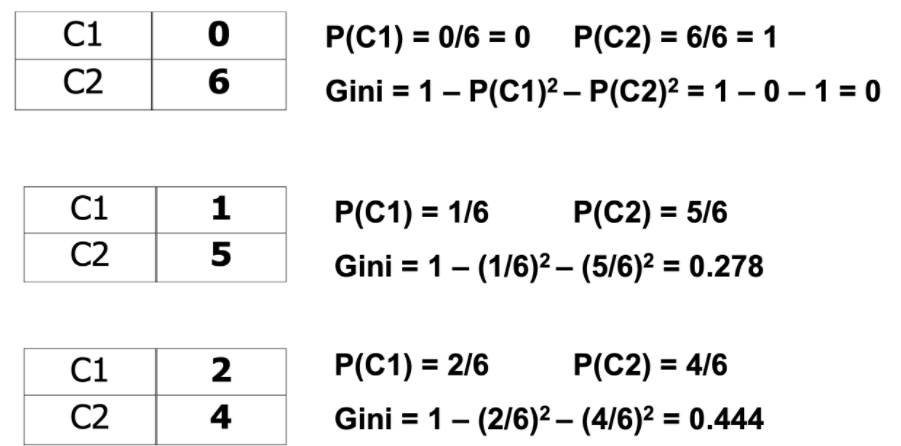

Agora, como podemos computar a melhoria no GINI quando um nó é dividido?

Lembre que queremos criar um nó grande e homogêneo.

Então, nós vamos ponderar o GINI de cada nó pelo número de elementos que ele contém.

Assim, a melhoria no GINI quando dividindo um nó com $N$ elementos é definido por:
$$\text{GINI}_{\text{NEW}} = \sum_i\frac{N_i}{N}\text{GINI}(i),$$
onde:
- $N_i$ é o numero de elementos no $i$-ésimo filho do nó $t$ e
- GINI$(i)$ é o GINI do $i$-ésimo filho do nó $t$.

Assim, uma divisão candidata tem melhoria no GINI dada por:
$$\text{GINI}(t) - \text{GINI}_{\text{NEW}}.$$


##### Exemplo para partições binárias

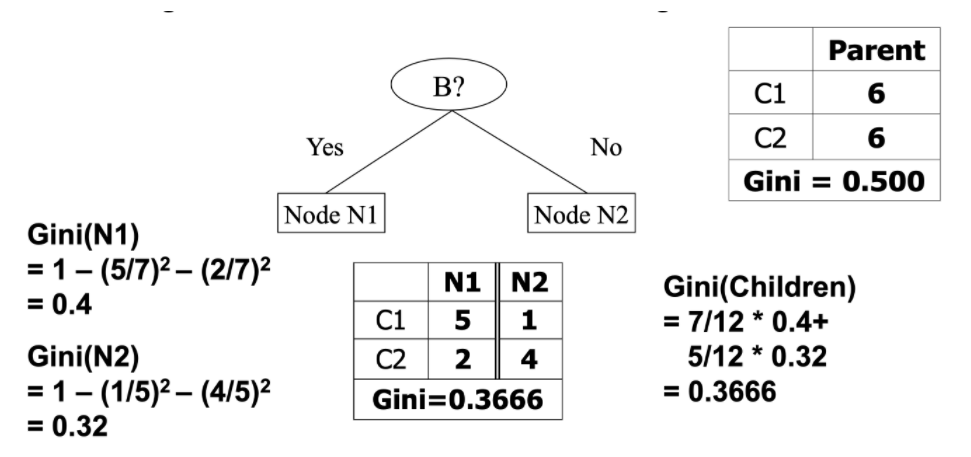

##### Exemplo para atributos nominais

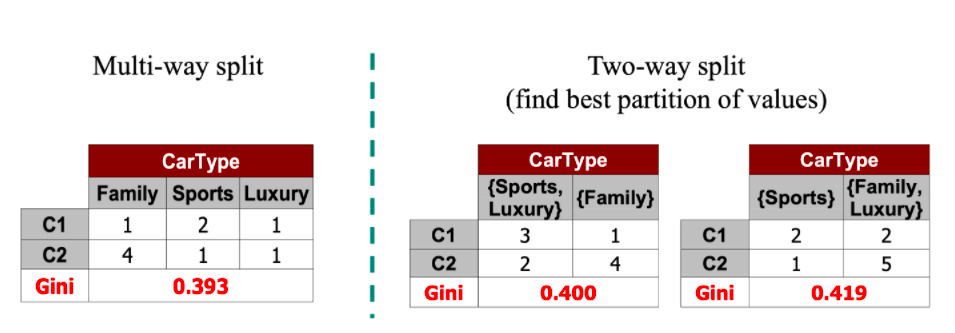

##### Exemplo para atributos contínuos

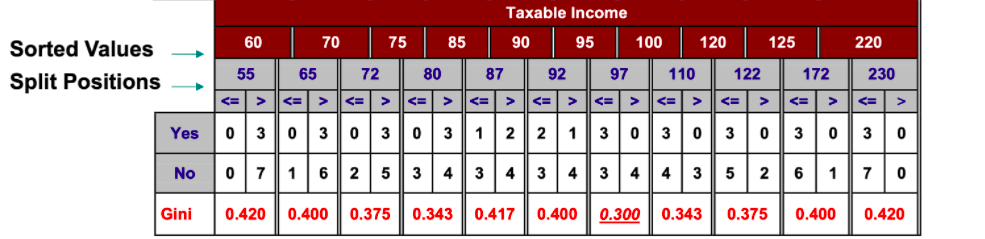

### Quando parar o processo de divisão?

Poderíamos continuar o processo de divisão até que todos os nós folha tivessem elementos pertencentes a apenas uma classe.

Por exemplo, cada nó folha poderia conter um único elemento do conjunto de treino.

Isso certamente criaria o problema de overfitting!

Há duas estratégias que podem ser utilizadas para controlar a complexidade de uma árvore de decisão:

1. *Early-stopping*: para o algoritmo antes que a árvore cresça demais
2. *Post-pruning*: cresça a ávore de descisão até que todas as folhas sejam completamente puras e após isso, faça um processo de poda.

*Early-stopping* é uma estratégia mais comum. Entre os possíveis critérios:
1. Pare se o número de elementos em um nó for menor que um valor definido
2. Pare se o processo de divisão for incapaz de melhorar a homogeneidade
3. Pare se a divisão for criar um nó com um número de elementos menor que um valor definido.

## Interpretação

Árvores de decisão são muito populares para classificação.

Elas têm as seguintes vantagens:
- Podem ser construídas de forma eficiente
- São eficientes para classificar novos elementos
- Têm boa acurácia em muitas situações
- São fáceis de ser **interpretadas**.

## Com a biblioteca *Scikit-learn*

In [ ]:
import graphviz
import pydotplus
from sklearn import tree

In [ ]:
X, y = datasets.load_digits(return_X_y = True)

In [ ]:
dt = tree.DecisionTreeClassifier()
_ = dt.fit(X, y)

In [ ]:
dt.predict(X) # Vale o mesmo Warning de antes. Fazendo isso aqui só de exemplo!

array([0, 1, 2, ..., 8, 9, 8])

### É possível visualizar a árvore

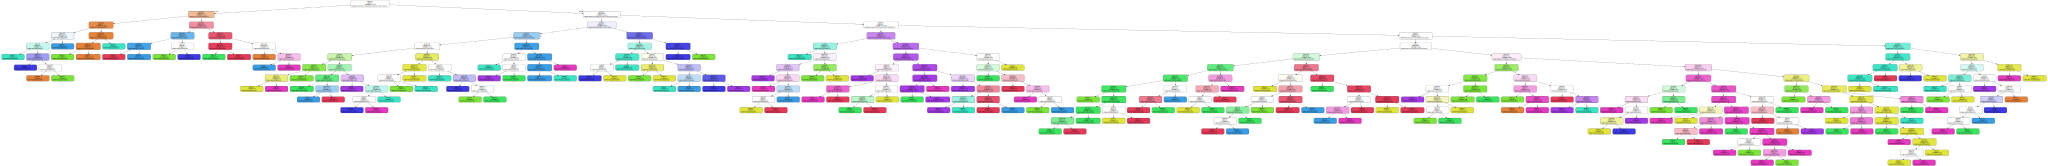

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None,
                     filled=True, rounded=True,
                     special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("dt-vis",view = True)
graph

# What is next?

- Como avaliar um modelo de classificação?